# Flame Speed

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Perform a sensitivity analysis of its kinetics

The figure below illustrates the setup, in a flame-fixed coordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="./images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

In [1]:
import cantera as ct
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['lines.linewidth'] = 2

print(f"Running Cantera version {ct.__version__}")

Running Cantera version 2.6.0


## Cantera Simulation Steps

Most Cantera simulations are accomplished by three steps:

1. Create a phase from an input file
2. Set boundary/input conditions
3. Run the simulation

In the case of an adiabatic free flame, Cantera has a built-in model to quickly calculate flame speeds.

### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [2]:
# Define the gas mixture and kinetics
# In this case, we are choosing a modified version of GRI 3.0
gas = ct.Solution('gri30.yaml')
gas()


  gri30:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   0.081894 kg/m^3
  mean mol. weight   2.016 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy             26469             53361  J
   internal energy       -1.2108e+06        -2.441e+06  J
           entropy             64910        1.3086e+05  J/K
    Gibbs function       -1.9447e+07       -3.9204e+07  J
 heat capacity c_p             14311             28851  J/K
 heat capacity c_v             10187             20536  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2                 1                 1           -15.717
     [  +52 minor]                 0                 0  



### Define flame simulation conditions

In [3]:
# Inlet temperature in kelvin and inlet pressure in pascal
To = 300
Po = 101325

# Domain width in meters
width = 0.02

# Set the inlet mixture to be stoichiometric CH4 and air 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po
gas()

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Set options for the solver
flame.transport_model = 'Mix'
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1


  gri30:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   1.1225 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -2.5459e+05       -7.0351e+06  J
   internal energy       -3.4485e+05       -9.5295e+06  J
           entropy            7247.7        2.0028e+05  J/K
    Gibbs function       -2.4289e+06       -6.7119e+07  J
 heat capacity c_p            1077.3             29770  J/K
 heat capacity c_v            776.45             21456  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -26.334
               CH4          0.055187          0.095057           -54.676
                N2           0.72467           0.71483           -23.369


### Run the simulation

With the input conditions set, we need to create the appropriate flame object and run the simulation. The `FreeFlame` class can take either an array of grid points or a width. Specifying the width is preferred and Cantera will automatically set and refine a grid in the simulation.

In [4]:
flame.solve(loglevel=loglevel, auto=True)
Su0_mix = flame.velocity[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0_mix*100))


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.192
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005474      4.219
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.653e-05      5.706
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.901e-05      5.857
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0009998      4.153
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.04 m
##############################################################################
Refining grid in flame.
    New points inserted after grid

In [5]:
# Chemkin style solution output
flame.show_solution()



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> reactants <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Mass Flux:       0.4303 kg/m^2/s 
    Temperature:        300 K 
    Mass Fractions: 
                      O2      0.2201 
                     CH4     0.05519 
                      N2      0.7247 



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> flame <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    Pressure:   1.013e+05 Pa

-------------------------------------------------------------------------------
          z    velocity  spread_rate           T      lambda      eField 
-------------------------------------------------------------------------------
          0      0.3833           0         300           0           0 
      0.004      0.3833           0         300           0           0 
      0.008      0.3833           0         300           0           0 
       0.01      0.3833           0         300           0           0 
      0.011      0.3833           0         300           0           0 
      0.

With 1-D flames, we need to consider species and energy transport by convection and diffusion. For species diffusion, there are several ways of calculating the binary diffusion coefficient of every pair of species. The simpler assumption is that the species is diffusing into an average mixture. The more complicated, but more accurate, assumption is to calculate the multi-component diffusion coefficients.

In this example, we are using the mixture-average assumption, with the `"Mix"` keyword. Using the `"Multi"` solution can substantially increase the time it takes to reach a solution.

However, you can start by solving the system with the mixture-average assumption and switch to the multicomponent assumption after a good initial solution has already been achieved.

In [6]:
flame.transport_model = 'Multi'

The auto option in the solve function tries to "automatically" solve the flame by applying a few common techniques. First, the flame is solved on a sparse grid with the transport calculations set to mixture averaged. Then grid refinement is enabled, with points added according to the values of the ratio, slope, and curve parameters in the set_refine_criteria function. If the initial solve on the sparse grid fails to converge, the simulation is attempted again, but this time with the energy equation disabled. Once the simulation has been solved on the refined grid with the mixture averaged transport, Cantera enables the multicomponent transport and Soret diffusion, if they have been set by the user.

In general, it is recommended that you use the auto option the first time you run the solver, unless the simulation fails. On subsequent invocations of solve, you should not include the auto option (or set it to False).

In [7]:
flame.solve(loglevel, auto=False)  # don't use 'auto' on subsequent solves
Su0_multi = flame.velocity[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0_multi*100))


..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [151] point grid(s).

..............................................................................
no new points needed in flame
Flame Speed is: 38.53 cm/s


Cantera can automatically refine the solution grid to meet certain criteria. 

In [8]:
flame.get_refine_criteria()

{'ratio': 3.0, 'slope': 0.1, 'curve': 0.1, 'prune': 0.0}

The four refinement parameters are `ratio`, `slope`, `curve`, and `prune`.

   * `ratio` limits the maximum distance between two grid points
   * `slope` adds grid points where the first derivative of the solution exceeds the threshold
   * `curve` adds grid points where the second derivative of the solution exceeds the threshold
   * `prune` will remove unnesseccary grid points in regions where the solution is over-refined (setting prune to 0.0 will preserve all solution points)


In [9]:
# Create a new flame object

# Set the inlet mixture to be stoichiometric CH4 and air 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Set options for the solver
flame.transport_model = 'Mix'
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

Cantera's 1-D solver can produce several levels of output, depending on how much detail you want to see. If you're pretty sure a solution is going to work, then a `loglevel` of 0 (no output) or 1 (minimal output) will be appropriate. If a case is failing, you can increase `loglevel` up to a maximum of 8 to have more and more output from each solution step.

In [10]:
# Define logging level
loglevel = 0

# Solve the flame
tic = time.time()
flame.solve(loglevel=loglevel, auto=True)
toc = time.time()

# Show refinement criteria
flame.get_refine_criteria()

#Show statistics for iteration to find solution
flame.show_stats()

Su0_mix = flame.velocity[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0_mix*100))
print("Calculation time is: {:.2f} s".format(toc-tic))


Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
   11          50       1307    3.1784         53   13.9085
   18           0       1854    8.8886         75   42.0113
   25          20        759    5.6286         30   26.5781
   34           0         58    0.6174          4    5.1213
   45          10        158    2.1871          5    8.6037
   56           0         13    0.2140          2    3.9206
   72           0         14    0.2987          1    2.1138
   95           0         10    0.2820          1    1.8710
  129           0          8    0.2946          1    1.9349
  153           0          6    0.2434          1    1.8999
Flame Speed is: 38.33 cm/s
Calculation time is: 14.18 s


Create a new flame object and set a higher refinement criteria to observe the difference in solution time and flamespeed.

In [11]:
# Create a new flame object

# Set the inlet mixture to be stoichiometric CH4 and air 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Create the flame object
flame_refined = ct.FreeFlame(gas, width=width)

# Set options for the solver
flame_refined.transport_model = 'Mix'

Set the new refinement criteria and solve.

In [12]:
# Set more strict refinement critieria
ratio = 2.0
slope = 0.05
curve = 0.05
prune = 0.0
flame_refined.set_refine_criteria(ratio=ratio,slope=slope,curve=curve,prune=prune)

# Solve flame
tic = time.time()
flame_refined.solve(loglevel=loglevel, auto=True)
toc = time.time()

# Show refinement criteria and statisitics for more refined flame
flame_refined.get_refine_criteria()
flame_refined.show_stats()
Su0_mix = flame_refined.velocity[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0_mix*100))
print("Calculation time is: {:.2f} s".format(toc-tic))


Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
   11          50       1307    3.2271         53   14.1652
   19           0       1854    9.9138         75   46.9627
   30          30        980    8.9805         37   40.8542
   42           0         37    0.4905          4    6.3828
   61          10        164    3.1286          5   10.4404
   81           0         13    0.3056          2    3.9713
  101           0         14    0.4439          1    1.9778
  129           0         10    0.3773          1    1.6820
  171           0          8    0.3839          1    1.5948
  239           0          6    0.3840          1    1.4671
  273           0          6    0.4239          1    1.4583
  275           0          2    0.0883          1    1.3953
Flame Speed is: 37.87 cm/s
Calculation time is: 19.98 s


### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see. We expect that the solution at the boundaries of the domain will have zero gradient (in other words, that the domain width that we specified is wide enough for the flame). Notice that Cantera automatically expanded the domain from 2 cm to 4 cm to accommodate the flame thickness.

#### Temperature Plot

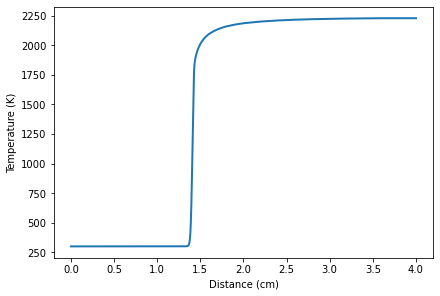

In [13]:
f, ax = plt.subplots(1, 1)
ax.plot(flame.grid*100, flame.T)
ax.set(xlabel='Distance (cm)', ylabel='Temperature (K)');

#### Major species plot

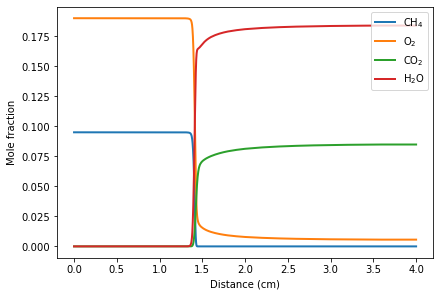

In [14]:
profile = ct.SolutionArray(gas, shape=len(flame.grid), extra={'z': flame.grid*100})
profile.TPY = flame.T, flame.P, flame.Y.T

f, ax = plt.subplots(1, 1)
ax.plot(profile.z, profile('CH4').X, label=r'CH$_4$')
ax.plot(profile.z, profile('O2').X, label=r'O$_2$')
ax.plot(profile.z, profile('CO2').X, label=r'CO$_2$')
plt.plot(profile.z, profile('H2O').X, label=r'H$_2$O')
ax.legend()
ax.set(xlabel='Distance (cm)', ylabel='Mole fraction');

#### Comparing Refinement Levels

(1.0, 2.0)

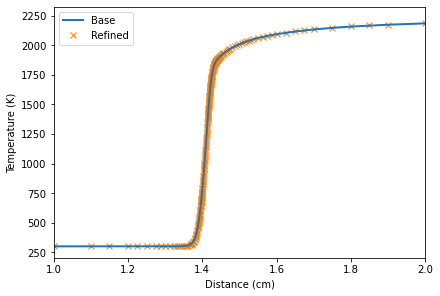

In [15]:
f, ax = plt.subplots(1, 1)

ax.plot(flame.grid*100, flame.T,'-',label=r'Base', zorder=2)
ax.plot(flame_refined.grid*100,flame_refined.T,'x',label=r'Refined', zorder=1)
ax.set(xlabel='Distance (cm)', ylabel='Temperature (K)');
ax.legend()
plt.xlim([1,2])

## Sensitivity analysis
Compute normalized sensitivities of flame speed $S_u$ to changes in the rate coefficient $k_i$ for each reaction
$$s_i = \frac{k_i}{S_u} \frac{d S_u}{d k_i}$$

Note that this will be much slower when multicomponent or Soret diffusion are turned on.

In [16]:
# Create a new flame object

# Set the inlet mixture to be stoichiometric CH4 and air 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Set options for the solver
flame.transport_model = 'Mix'
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
flame.solve(loglevel=1, auto=True)


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.192
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005474      4.219
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.653e-05      5.706
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.901e-05      5.857
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0009998      4.153
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.04 m
##############################################################################
Refining grid in flame.
    New points inserted after grid

In [17]:
sens = flame.get_flame_speed_reaction_sensitivities()
# note: much slower for multicomponent / Soret

In [18]:
# Find the most important reactions:
sens_data = [(sens[i], gas.reaction_equation(i)) for i in range(gas.n_reactions)]
sens_data.sort(key=lambda item: abs(item[0]), reverse=True)
for s, eq in sens_data[:20]:
    print(f'{s: .2e}  {eq}')

 5.35e-01  H + O2 <=> O + OH
-1.62e-01  CH3 + H (+M) <=> CH4 (+M)
 1.15e-01  CO + OH <=> CO2 + H
 7.43e-02  CH3 + OH <=> CH2(S) + H2O
 7.30e-02  CH3 + HO2 <=> CH3O + OH
-7.03e-02  H + O2 + H2O <=> HO2 + H2O
 5.84e-02  HCO + H2O <=> CO + H + H2O
 5.32e-02  CH3 + O => CO + H + H2
 4.53e-02  HCO + M <=> CO + H + M
-3.97e-02  H + HO2 <=> H2 + O2
-3.92e-02  CH4 + OH <=> CH3 + H2O
-3.90e-02  H + HCO <=> CO + H2
-3.80e-02  CH4 + H <=> CH3 + H2
-3.74e-02  2 CH3 (+M) <=> C2H6 (+M)
-3.42e-02  H + OH + M <=> H2O + M
-3.04e-02  HCO + O2 <=> CO + HO2
 2.79e-02  H2 + O <=> H + OH
 2.68e-02  CH2 + O2 => CO2 + 2 H
-2.07e-02  HCO + OH <=> CO + H2O
 1.90e-02  CH2(S) + O2 <=> CO + H + OH


/var/folders/d4/mt_nqf_x42vgxs9t9mw1l59m0000gn/T/ipykernel_41902/773482251.py:2: DeprecationWarning: 'reaction_equation' is deprecated and will be removed after Cantera 2.6.
Replaceable by property 'equation' of the corresponding reaction object.
  sens_data = [(sens[i], gas.reaction_equation(i)) for i in range(gas.n_reactions)]


## Solving multiple flames (parameter sweep) 

Cantera also makes it easy to re-use solutions from previous flames to compute conditions for a similar flame. This is very useful when doing a parameter sweep. In this case, we are going to sweep over a range of equivalence ratios. We will start at the lower limit of the equivalence ratio range we are interested in, 0.6.

In [19]:
# Start  at one limit of the equivalence ratio range
gas.set_equivalence_ratio(0.6, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

flame = ct.FreeFlame(gas, width=width)

In the grid refinement criteria, it is important that we add one more condition, `prune`. This parameter controls when grid points can be removed from the simulation. Since we are conducting a sweep of equivalence ratios here, we expect the flame thickness to vary so that the number of grid points necessary will vary as well. Without `prune`, the number of grid points could never decrease and it would slow down some of the solutions.

In [20]:
# Enabling pruning is important to avoid continuous increase in grid size
flame.set_refine_criteria(ratio=3, slope=0.15, curve=0.15, prune=0.1)

Now we will solve the flame. For this first case, we are going to set `auto=True`.

In [21]:
flame.solve(loglevel=0, refine_grid=True, auto=True)

Now we will construct the range of equivalence ratios to loop over. Notice that the rest of these solutions are conducted with `auto=False`, since we are starting from a known-good solution.

In [22]:
phis = np.linspace(0.6, 1.8, 50)
Su = []

for phi in phis:
    gas.set_equivalence_ratio(phi, 'CH4', {'O2':1.0, 'N2':3.76})
    flame.inlet.Y = gas.Y
    flame.solve(loglevel=0, refine_grid=True, auto=False)
    print(f'phi = {phi:.3f}: Su = {flame.velocity[0]*100:5.2f} cm/s, N = {len(flame.grid)}')
    Su.append(flame.velocity[0])

phi = 0.600: Su = 11.66 cm/s, N = 88
phi = 0.624: Su = 13.60 cm/s, N = 91
phi = 0.649: Su = 15.54 cm/s, N = 96
phi = 0.673: Su = 17.55 cm/s, N = 109
phi = 0.698: Su = 19.60 cm/s, N = 117
phi = 0.722: Su = 21.63 cm/s, N = 119
phi = 0.747: Su = 23.52 cm/s, N = 123
phi = 0.771: Su = 25.48 cm/s, N = 124
phi = 0.796: Su = 27.43 cm/s, N = 127
phi = 0.820: Su = 29.22 cm/s, N = 130
phi = 0.845: Su = 30.94 cm/s, N = 135
phi = 0.869: Su = 32.55 cm/s, N = 131
phi = 0.894: Su = 34.03 cm/s, N = 131
phi = 0.918: Su = 35.36 cm/s, N = 131
phi = 0.943: Su = 36.52 cm/s, N = 131
phi = 0.967: Su = 37.52 cm/s, N = 132
phi = 0.992: Su = 38.31 cm/s, N = 132
phi = 1.016: Su = 38.87 cm/s, N = 132
phi = 1.041: Su = 39.12 cm/s, N = 133
phi = 1.065: Su = 39.19 cm/s, N = 133
phi = 1.090: Su = 39.00 cm/s, N = 133
phi = 1.114: Su = 38.50 cm/s, N = 133
phi = 1.139: Su = 37.70 cm/s, N = 133
phi = 1.163: Su = 36.56 cm/s, N = 135
phi = 1.188: Su = 35.09 cm/s, N = 135
phi = 1.212: Su = 33.27 cm/s, N = 135
phi = 1.237: Su

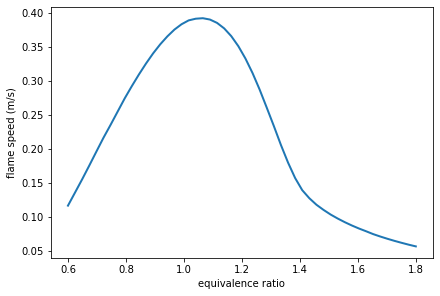

In [23]:
f, ax = plt.subplots(1, 1)
ax.plot(phis, Su)
ax.set(xlabel='equivalence ratio', ylabel='flame speed (m/s)');

## Challenge question: Evaluating NO<sub>x</sub> formation for freely propagating flames
Nitrogen oxides or NO<sub>x</sub> is a unavoidable pollutant for any combustion device that uses air as an oxidizer. NO<sub>x</sub> refers to two nitrogen compounds:
 * NO<sub>2</sub>: yellow/brown corrosive, toxic gas responsible for photochemical smog and ozone depletion
 * NO: A toxic gas which reacts with ozone to produce NO<sub>2</sub>
 
NO<sub>x</sub> is essentially unavoidable in any combustion system that uses air as an oxidizer, as the presence of oxygen and nitrogen at high temperatures will produce NO<sub>x</sub>. When designing a combustion device, care must be taken to minimize the amount of NO<sub>x</sub> formed, and NO<sub>x</sub> emissions are heavily regulated.

To better understand how to mitigate NO<sub>x</sub> formation, and to test your skills learned in this lesson, write a code that will record and plot the NO and NO<sub>2</sub> mole fractions at the outlet from your combustor (the final point in your flame solution). Continue to use methane as fuel and air as the oxidizer, as well as the GRI 3.0 chemical kinetics model. In particular, you should evaluate the effect of varying:
 * Equivalence ratio
 * Ambient pressure Po
 * Fresh fuel/oxidizer mixture temperature To
 
# Bonus
Extend your code to also consider the effect of residence time on mole fractions of NO and NO<sub>2</sub>

Hints:
 * Residence time can be calculated from flame.grid and flame.velocity
 * Make the solution domain larger to allow for longer residence times